In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)    # modify ylims to focus on region of interest

# Method to reproject lat/lon onto Lambert coordinates
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

---
## **Maps of event**

### **MODIS active fires**

Downloaded from https://firms.modaps.eosdis.nasa.gov/active_fire/

In [238]:
sf = gpd.read_file("sf_hfr").to_crs(cproj)
countries = gpd.read_file("../../Data/sf_countries").to_crs(cproj)

In [46]:
fires = pd.concat([gpd.read_file(fnm) for fnm in glob.glob("firms/sf_modis-*")]).to_crs(cproj)
fires["y"] = [int(d[:4]) for d in fires.ACQ_DATE]
fires["m"] = [int(d[5:7]) for d in fires.ACQ_DATE]

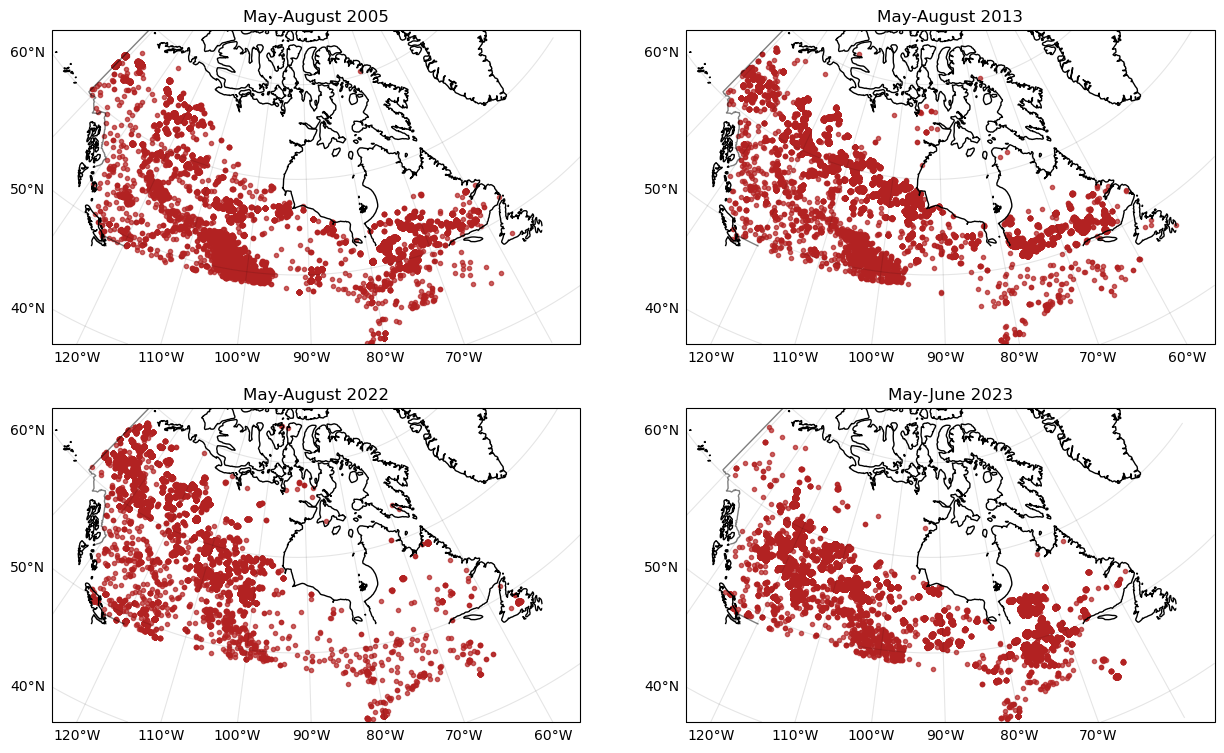

In [236]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15,9), dpi = 100, subplot_kw = {"projection" : cproj})

for i in range(4):
    
    Y = [2005,2013,2022,2023][i]
    ax = fig.axes[i]
    fires.loc[[y == Y for y in fires.y]].plot(ax = ax, marker = ".", color = "firebrick", alpha = 0.7)
    ax.set_title("May-August "+str(Y))

fig.axes[-1].set_title("May-June 2023")
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)
    
    ax.set_xlim(*cproj.bounds[:2])
    ax.set_ylim(*cproj.bounds[2:])

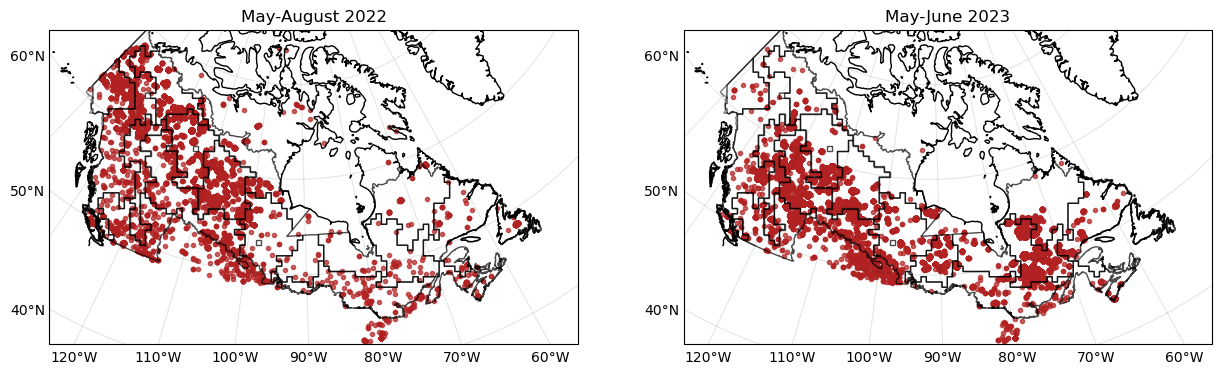

In [239]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15,5), dpi = 100, subplot_kw = {"projection" : cproj})

for i in range(2):
    
    Y = [2022,2023][i]
    ax = fig.axes[i]
    fires.loc[[y == Y for y in fires.y]].plot(ax = ax, marker = ".", color = "firebrick", alpha = 0.7)
    ax.set_title("May-August "+str(Y))

fig.axes[-1].set_title("May-June 2023")
for ax in fig.axes:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)
    
    ax.set_xlim(*cproj.bounds[:2])
    ax.set_ylim(*cproj.bounds[2:])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


(750000.0, 4340847.387925235)

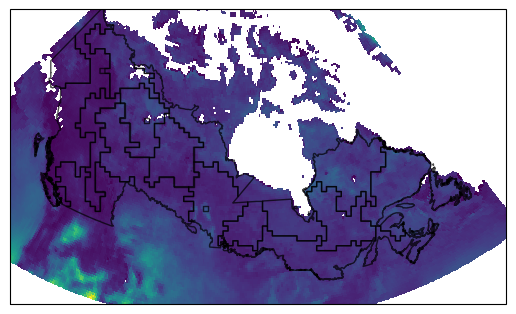

In [90]:
da = xr.open_dataset("data/percentile_99_map.nc").fwi
x,y = latlon_to_lambert(da)

fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
ax.pcolormesh(x,y,da)

sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)

ax.set_xlim(*cproj.bounds[:2])
ax.set_ylim(*cproj.bounds[2:])

#### **Fires per HFR**

In [96]:
zz = gpd.overlay(fires, sf, how='intersection')

In [154]:
nfires = zz[["y","m","NAMES_SHOR"]].groupby(["y", "NAMES_SHOR"]).count().unstack()

In [155]:
nfires

m                                                         \
NAMES_SHOR    EJB    ES    ET   GBL   GSL    IC     LA    LW   NAT     P   
y                                                                          
2005         3971   954   454  4188  1787   286   2181   769   904  1191   
2013        12045  2519    86  1980  5300   760   7047  3343  3585   422   
2022           31   130   150  4341  4524  3089   4459   959   224  1977   
2023        21126  2062  1634   405  9548  8737  13948   863  1225  2307   

                                                 
NAMES_SHOR    SC     SP    SY  WJB    WO     WS  
y                                                
2005         335   1883  1422  309   249     93  
2013         208   4813  2884  270   271  11112  
2022        1094   1231  1728   17    15    381  
2023        5665  34689    29  683  2261    465

### **fwi7x**

In [2]:
# # Monthly maximum of 7-day rolling mean of FWI
# fwi7x = []
# for y in range(1940,2030,10):
    
#     fwi = xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi.load()
#     rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(fwi.longitude, fwi.latitude).sel(region = 3).reset_coords(drop = True)

#     fwi7 = fwi.where(rm == 1).rolling(time = 7).mean().resample(time = "MS").max()
#     fwi7x.append(fwi7)

# fwi7x = xr.concat(fwi7x, "time").rename("fwi7x")
# fwi7x.to_netcdf("data/era5_fwi7x-monthly.nc")

In [2]:
fwi7x = xr.open_dataset("data/era5_fwi7x-monthly.nc").fwi7x


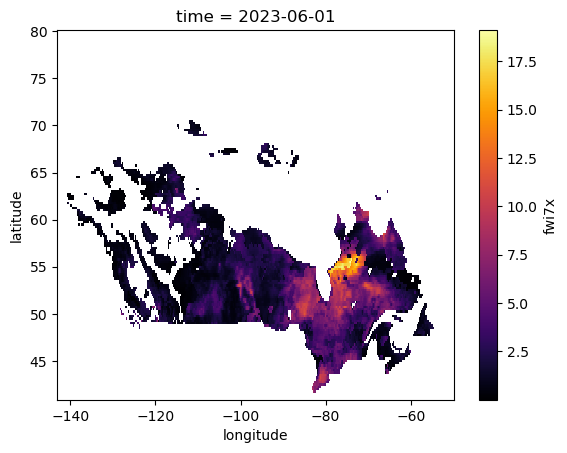

In [9]:
fwi7x.sel(time = "2023-06").plot(cmap = "inferno")


### **fwiq99**

In [19]:
fwi99_mj = fwi.sel(time = [m in [5,6] for m in fwi.time.dt.month]).resample(time = "AS-DEC", label = "right").quantile(0.99)
fwi99_mj = fwi99_mj.assign_attrs(note = "99th percentile of FWI during May and June in each grid cell")
fwi99_mj.to_netcdf("data/fwi99-mj_era5_1941-2023")

In [15]:
fwi99_mj.isel(time = slice(-5,None)).plot(col = "time", vmax = 20, vmin = 0, cmap = "inferno")

In [34]:
sf = gpd.read_file("sf_hfr").to_crs(cproj)

da = xr.open_dataset("data/percentile_99_map.nc").fwi
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.longitude, da.latitude).sel(region = 3).reset_coords(drop = True)

Text(0.5, 1.0, '99th percentile of FWI during May-June 2023 (ERA5)')

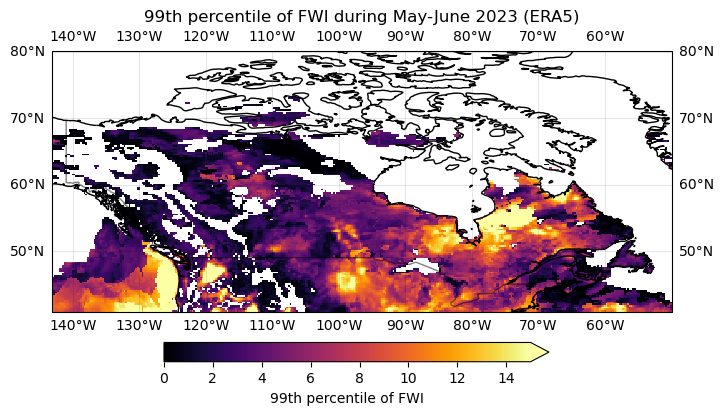

In [21]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

fwi99_mj.isel(time = -1).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, '99th percentile of FWI during May-June 2023 (ERA5)')

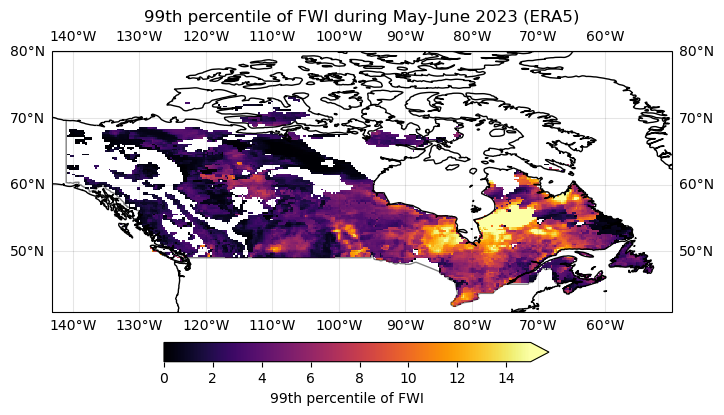

In [35]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

fwi.sel(time = slice("2023-05", "2023-06")).quantile(0.99, "time").where(rm).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

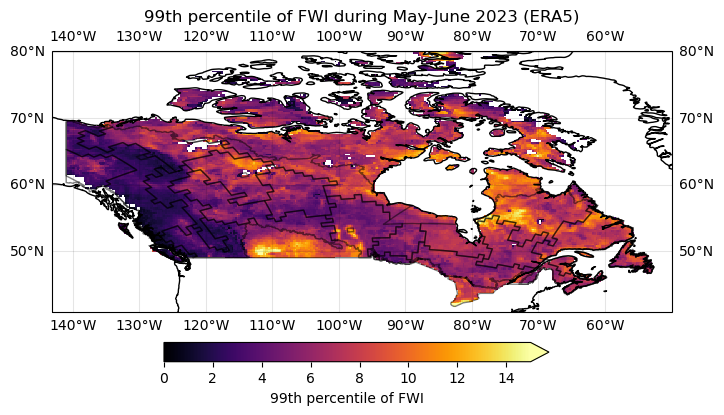

In [36]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

da.where(rm).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

sf.boundary.plot(ax = ax, lw = 1, color = "k", alpha = 0.5)

# [ax.annotate(text = v.NAMES_SHOR, xy = (v.geometry.representative_point().x, v.geometry.representative_point().y)) for k,v in sf.iterrows()]

plt.savefig("fig/fwi99-map.png")

### **Monthly severity rating**

In [5]:
# # Monthly mean of daily severity rating
# msr = []
# for y in range(1940,2030,10):
    
#     dsr = (xr.open_mfdataset("data/era5/fwi_era5_"+str(y)+"-"+str(y+9)+".nc").fwi ** 1.71) * 0.0272
#     rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(fwi.longitude, fwi.latitude).sel(region = 3).reset_coords(drop = True)
#     msr.append(dsr.where(rm == 1).resample(time = "MS").mean())

# msr = xr.concat(msr, "time").rename("msr")
# msr.to_netcdf("data/era5_monthly-severity-rating.nc")

In [194]:
msr = xr.open_dataset("data/era5_monthly-severity-rating.nc").msr

# Remove everything but Canada
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.longitude, da.latitude).sel(region = 3).reset_coords(drop = True)
msr = msr.where(rm).dropna("time", "all")
msr = msr.sel(time = [m in [5,6,7,8,9] for m in msr.time.dt.month])

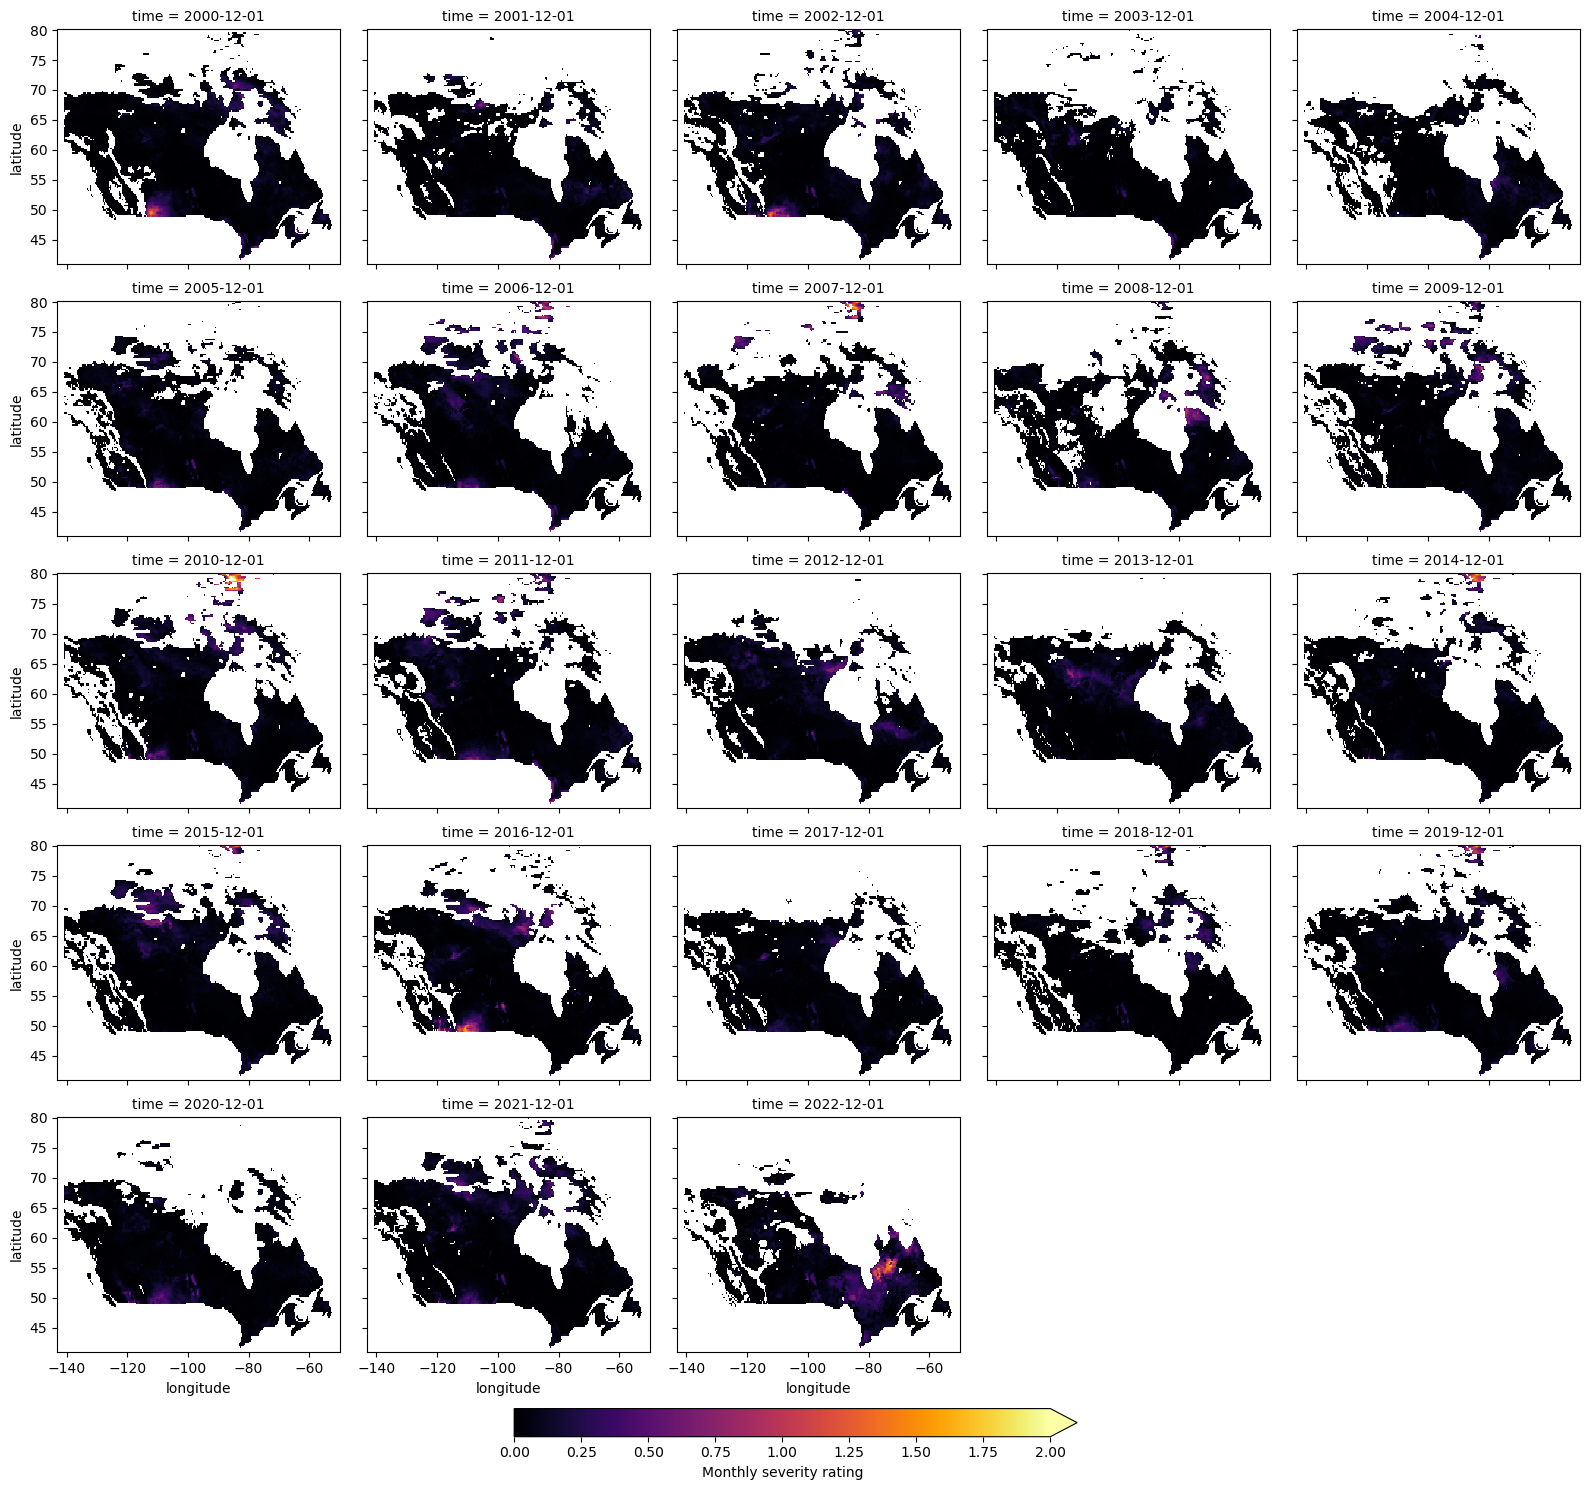

In [210]:
msr.resample(time = "AS-DEC").mean().sel(time = slice("2000","2023")).plot(col = "time", col_wrap = 5, cmap = "inferno", vmax = 2,
                                                                           cbar_kwargs = {"location" : "bottom", "fraction" : 0.02, "label" : "Monthly severity rating", "pad" : 0.04})

In [ ]:
sf = gpd.read_file("sf_hfr").to_crs(cartopy.crs.PlateCarree())

In [ ]:
hfr_rm = regionmask.mask_3D_geopandas(sf, msr.longitude, msr.latitude, numbers = "grid60km_n")

In [246]:
hfr_east = hfr_rm.sel(region = [r in [7,12,5,1,9] for r in hfr_rm.region]).sum("region")
hfr_east = hfr_east.where(hfr_east == 1)

In [251]:
hfr_west = hfr_rm.sel(region = [r in [15,2,3] for r in hfr_rm.region]).sum("region")
hfr_west = hfr_west.where(hfr_west == 1)

In [ ]:
hfr_rm = regionmask.mask_3D_geopandas(sf, msr.longitude, msr.latitude)
hfr_msr = msr.where(hfr_rm)

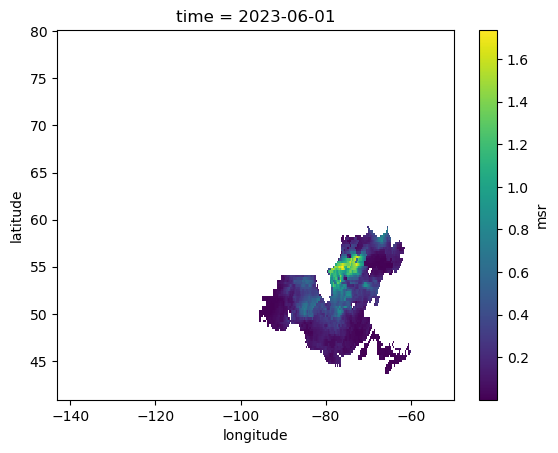

In [255]:
msr.where(hfr_east == 1).isel(time = -1).plot()

# if using, retain only the contiguous region
